In [2]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
#from train import train

In [3]:
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path)

In [25]:
file = dic_files['서울']
file

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
0,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-20
1,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-21
2,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-22
3,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-23
4,0,1,서울,Seoul,1,0,1,0,1,0.0,2020-01-24
...,...,...,...,...,...,...,...,...,...,...,...
1167,6383,5991150,서울,Seoul,2523,0,0,2522,1,63544.0,2023-04-01
1168,6383,5993551,서울,Seoul,2401,0,0,2401,0,63569.0,2023-04-02
1169,6384,5994393,서울,Seoul,842,0,0,842,0,63578.0,2023-04-03
1170,6387,5997981,서울,Seoul,3588,0,0,3588,0,63616.0,2023-04-04


In [78]:
df = pd.DataFrame()

df['Date'] = file['stdDay']
df['city'] = file['gubun']
df['Death'] = file['deathCnt']               # 누적 사망자 수
df['Death_daily'] = df['Death'].diff().fillna(0)   # 일일 사망자
df['Inf_AC'] = file['defCnt']                   # 누적 감염자
df['Inf_daily'] = df['Inf_AC'].diff().fillna(0)

Recover1 = 7     # 자가격리 해제 기간
Recover2 = 14    # 변이별 데이터가 없기 때문에 14일만 사용함

# 현재 격리중인 환자 수 (= 전염 가능자)
# t일 감염자 수 = t일 누적 감염자 수 - (t-14)일 누적 감염자 수
df['Infected'] = df['Inf_AC'] 
df.iloc[Recover2:, -1] = (df.iloc[Recover2:, -1]
                          .reset_index(drop = True)
                          .sub(df.iloc[:len(df) - Recover2, -1]))

Total = 9776000     # 서울시 인구 ( 2017년 기준 )
Reinfectable = 90   # 면역력 보유 기간

# 누적 회복자 수 (= 감염 되었다가 격리 해제 된 인원 누적값, 90일 이후 면역 사라짐)
# t일 누적 회복자 수 = (t-14)일 누적 감염자 수 - t일 누적 사망자 수
df['Recovered_AC'] = 0
df.iloc[Recover2:, -1] = df.iloc[:len(df) - Recover2, 4].sub(df.iloc[Recover2:, 2].reset_index(drop = True))

# 회복자 수 (= 감염 가능성 X)
# t일 회복자 수 = (t-14)일 누적 감염자 수 - t일 누적 사망자 수 - (t-90)일 누적 회복자 수 
df['Recovered'] = df['Recovered_AC']
df.iloc[Reinfectable:, -1] = (df.iloc[Reinfectable:, -1]
                              .reset_index(drop = True)
                              .sub(df.iloc[:len(df) - Reinfectable, -1]))

df['Survived'] = Total
df['Survived'] = df['Survived'] - df['Infected'] - df['Recovered'] - df['Death']

df

,Date,city,Death,Death_daily,Inf_AC,Inf_daily,Infected,Recovered_AC,Recovered,Survived
0,2020-01-20,서울,0,0.0,0,0.0,0,0,0,9776000
1,2020-01-21,서울,0,0.0,0,0.0,0,0,0,9776000
2,2020-01-22,서울,0,0.0,0,0.0,0,0,0,9776000
3,2020-01-23,서울,0,0.0,0,0.0,0,0,0,9776000
4,2020-01-24,서울,0,0.0,1,1.0,1,0,0,9775999
...,...,...,...,...,...,...,...,...,...,...
1167,2023-04-01,서울,6383,1.0,5991150,2108.0,31389,5953378,457779,9280449
1168,2023-04-02,서울,6383,0.0,5993551,2401.0,31920,5955248,455468,9282229
1169,2023-04-03,서울,6384,1.0,5994393,842.0,32073,5955936,437938,9299605
1170,2023-04-04,서울,6387,3.0,5997981,3588.0,32819,5958775,425227,9311567


In [102]:
df2 = df.copy()

df2['alpha'] = df2['Survived'].diff().fillna(0)
df3 = df2.copy()
df2.iloc[Reinfectable:, -1] = (df2.iloc[Reinfectable:, -1]
                              .reset_index(drop = True)
                              .sub(df2.iloc[:len(df2) - Reinfectable, -4]))
df4 = df2.copy()
df2['alpha'] = (-1 * Total * df2['alpha'])/(df2['Survived'] * df2['Infected'])




df2

,Date,city,Death,Death_daily,Inf_AC,Inf_daily,Infected,Recovered_AC,Recovered,Survived,alpha
0,2020-01-20,서울,0,0.0,0,0.0,0,0,0,9776000,NaN
1,2020-01-21,서울,0,0.0,0,0.0,0,0,0,9776000,NaN
2,2020-01-22,서울,0,0.0,0,0.0,0,0,0,9776000,NaN
3,2020-01-23,서울,0,0.0,0,0.0,0,0,0,9776000,NaN
4,2020-01-24,서울,0,0.0,1,1.0,1,0,0,9775999,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1167,2023-04-01,서울,6383,1.0,5991150,2108.0,31389,5953378,457779,9280449,184.142703
1168,2023-04-02,서울,6383,0.0,5993551,2401.0,31920,5955248,455468,9282229,181.405632
1169,2023-04-03,서울,6384,1.0,5994393,842.0,32073,5955936,437938,9299605,180.288866
1170,2023-04-04,서울,6387,3.0,5997981,3588.0,32819,5958775,425227,9311567,176.635063


In [96]:
df3[500:520]

,Date,city,Death,Death_daily,Inf_AC,Inf_daily,Infected,Recovered_AC,Recovered,Survived,alpha
500,2021-06-03,서울,495,3.0,44534,215.0,2635,41404,14692,9758178,-38.0
501,2021-06-04,서울,496,1.0,44740,206.0,2669,41575,14742,9758093,-85.0
502,2021-06-05,서울,496,0.0,45017,277.0,2738,41783,14821,9757945,-148.0
503,2021-06-06,서울,497,1.0,45196,179.0,2736,41963,14897,9757870,-75.0
504,2021-06-07,서울,497,0.0,45355,159.0,2756,42102,14911,9757836,-34.0
505,2021-06-08,서울,498,1.0,45494,139.0,2757,42239,14906,9757839,3.0
506,2021-06-09,서울,499,1.0,45677,183.0,2679,42499,15045,9757777,-62.0
507,2021-06-10,서울,499,0.0,45889,212.0,2673,42717,15133,9757695,-82.0
508,2021-06-11,서울,499,0.0,46093,204.0,2663,42931,15219,9757619,-76.0
509,2021-06-12,서울,499,0.0,46301,208.0,2677,43125,15294,9757530,-89.0


In [99]:
-1 * Total * df4['alpha']

0      -0.000000e+00
1      -0.000000e+00
2      -0.000000e+00
3      -0.000000e+00
4       9.776000e+06
            ...     
1167    7.146979e+12
1168    7.158955e+12
1169    7.112793e+12
1170    7.257712e+12
1171    7.352549e+12
Name: alpha, Length: 1172, dtype: float64

In [100]:
df['Survived'] * df['Infected']

0                  0
1                  0
2                  0
3                  0
4            9775999
            ...     
1167    291304013661
1168    296288749680
1169    298266231165
1170    305596317373
1171    311816628799
Length: 1172, dtype: int64

In [ ]:
df2['alpha'] = (-1 * Total * (df['Survived'].diff().fillna(0)[1:].reset_index(drop = True))) / (df['Survived'] * df['Infected'])
df2.iloc[Reinfectable:-1, -1] = (-1 * Total * (df['Survived'].diff().fillna(0)[Reinfectable + 1:].reset_index(drop = True).sub(df.iloc[:len(df) - Reinfectable - 1, 3]))) / (df['Survived'][Reinfectable:-1].reset_index(drop = True) + df['Infected'][Reinfectable:-1].reset_index(drop = True))
df2.loc[df2['alpha'] == 0, 'alpha'] = 0
df2['beta'] = (df['Recovered_Ori'].diff()[1:].reset_index(drop = True)) / df['Infected']
df2['gamma'] = (df['Death_AC'].diff()[1:].reset_index(drop = True)) / df['Infected']
#df2['beta'] = 1-df2['gamma']

df2.head(20)

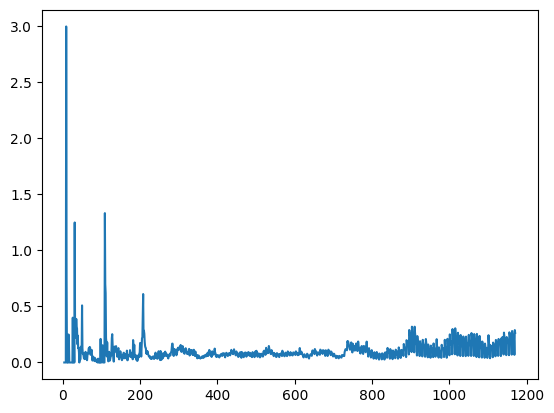

In [24]:
plt.plot(df2['alpha'])

2020년 09월 12일 이전 사망까지 걸리는 시간 평균 19.5일 
<br/> 
이후 평균 13.6일로 감소

In [426]:
df_final = df[['Date', 'Survived', 'Infected', 'Recovered', 'Death', 'alpha', 'beta', 'gamma']]
df_final

KeyError: "['alpha', 'beta', 'gamma'] not in index"

In [395]:
df['Survived'].diff().fillna(0)[1:].reset_index(drop = True)[Reinfectable:]

90          0.0
91         -2.0
92         -2.0
93          0.0
94          0.0
         ...   
1166     8541.0
1167     1790.0
1168    17381.0
1169    11976.0
1170    10593.0
Name: Survived, Length: 1081, dtype: float64

In [396]:
df.iloc[:len(df) - Reinfectable - 1, 3]

0             0
1             0
2             0
3             0
4             1
         ...   
1076    5663251
1077    5673241
1078    5676545
1079    5693511
1080    5707426
Name: Inf_AC, Length: 1081, dtype: int64

In [381]:
df['Survived'].diff().fillna(0)[1:].reset_index(drop = True)[Reinfectable:] / (df['Survived'][Reinfectable:-1] * df['Infected'][Reinfectable:-1])

90      0.000000e+00
91     -3.354028e-09
92     -3.467725e-09
93      0.000000e+00
94      0.000000e+00
            ...     
1166    2.953282e-08
1167    6.140770e-09
1168    5.862400e-08
1169    4.012581e-08
1170    3.464071e-08
Length: 1081, dtype: float64

In [383]:
(df['Survived'][Reinfectable:-1] * df['Infected'][Reinfectable:-1])

90      7.038271e+08
91      5.962979e+08
92      5.767471e+08
93      4.887686e+08
94      3.714641e+08
            ...     
1166    2.892037e+11
1167    2.914944e+11
1168    2.964827e+11
1169    2.984612e+11
1170    3.057963e+11
Length: 1081, dtype: float64

In [385]:
df.iloc[:len(df) - Reinfectable - 1, 3]

0             0
1             0
2             0
3             0
4             1
         ...   
1076    5663251
1077    5673241
1078    5676545
1079    5693511
1080    5707426
Name: Inf_AC, Length: 1081, dtype: int64

In [386]:
(df['Survived'][Reinfectable:-1] + df['Infected'][Reinfectable:-1])

90      9775448.0
91      9775437.0
92      9775433.0
93      9775422.0
94      9775410.0
          ...    
1166    9309144.0
1167    9317903.0
1168    9320224.0
1169    9337758.0
1170    9350480.0
Length: 1081, dtype: float64

In [287]:

Recover1 = 7
Recover2 = 14

df['Infected'] = df['Inf_AC']
df.iloc[Recover2:, -1] = (df.iloc[Recover2:, -1]
                          .reset_index(drop = True)
                          .sub(df.iloc[:len(df) - Recover2, -1]))
df[df['Infected'] < 0]

,Date,Death_AC,Death,Inf_AC,Infected


In [324]:
Total = 9776000
Reinfectable = 90

df['Recovered'] = 0
df.iloc[Recover2:, -1] = df.iloc[:len(df) - Recover2, 3]
#print(df[-50:])
df.iloc[Reinfectable:, -1] = (df.iloc[Reinfectable:, -1]
                              .reset_index(drop = True)
                              .sub(df.iloc[:len(df) - Reinfectable, -1]))
df['Recovered'] = df['Recovered'] - df['Death']

df['Survived'] = Total
df['Survived'] = df['Survived'] - df['Infected'] - df['Recovered'] - df['Death']


df.head()

,Date,Death_AC,Death,Inf_AC,Infected,Recovered,Survived
0,2020-01-20,0,0.0,0,0,0.0,9776000.0
1,2020-01-21,0,0.0,0,0,0.0,9776000.0
2,2020-01-22,0,0.0,0,0,0.0,9776000.0
3,2020-01-23,0,0.0,0,0,0.0,9776000.0
4,2020-01-24,0,0.0,1,1,0.0,9775999.0


In [323]:
df['Survived'] = Total
df['Survived'] = df['Survived'] - df['Infected'] - df['Recovered'] - df['Death']

df

,Date,Death_AC,Death,Inf_AC,Infected,Recovered,Survived
0,2020-01-20,0,0.0,0,0,0.0,9776000.0
1,2020-01-21,0,0.0,0,0,0.0,9776000.0
2,2020-01-22,0,0.0,0,0,0.0,9776000.0
3,2020-01-23,0,0.0,0,0,0.0,9776000.0
4,2020-01-24,0,0.0,1,1,0.0,9775999.0
...,...,...,...,...,...,...,...
1167,2023-04-01,6383,1.0,5991150,31389,458096.0,9286514.0
1168,2023-04-02,6383,0.0,5993551,31920,455776.0,9288304.0
1169,2023-04-03,6384,1.0,5994393,32073,438241.0,9305685.0
1170,2023-04-04,6387,3.0,5997981,32819,425517.0,9317661.0


In [213]:
Total = 9776000
df['Survived'] = Total - df[['Infected']]
df.iloc[Reinfectable:, -1] = (df.iloc[Reinfectable:, -1]
                              .reset_index(drop = True)
                              .add(df.iloc[:len(df) - Reinfectable, 1]))
df

,Date,Infected,Death,Recovered,Survived
0,2020-01-20,0,0,0,9776000
1,2020-01-21,0,0,0,9776000
2,2020-01-22,0,0,0,9776000
3,2020-01-23,0,0,0,9776000
4,2020-01-24,1,0,0,9775999
...,...,...,...,...,...
1167,2023-04-01,2523,6383,-8063,9783467
1168,2023-04-02,2401,6383,-1434,9776903
1169,2023-04-03,842,6384,-16277,9792124
1170,2023-04-04,3588,6387,-11073,9786327


In [61]:
df['Total'] = 9776000
df['Surv'] = df['Total'] - df['defCnt']
df['Inf'] = 

,Unnamed: 0,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay,Total,Surv
0,0,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-20,9776000,9776000
1,1,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-21,9776000,9776000
2,2,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-22,9776000,9776000
3,3,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-23,9776000,9776000
4,4,0,1,서울,Seoul,1,0,1,0,1,0.0,2020-01-24,9776000,9775999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,1167,6383,5991150,서울,Seoul,2523,0,0,2522,1,63544.0,2023-04-01,9776000,3784850
1168,1168,6383,5993551,서울,Seoul,2401,0,0,2401,0,63569.0,2023-04-02,9776000,3782449
1169,1169,6384,5994393,서울,Seoul,842,0,0,842,0,63578.0,2023-04-03,9776000,3781607
1170,1170,6387,5997981,서울,Seoul,3588,0,0,3588,0,63616.0,2023-04-04,9776000,3778019


In [60]:
df.iloc[0:5, -1] = 0
df

,Unnamed: 0,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay,Total,Surv
0,0,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-20,9776000,0
1,1,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-21,9776000,0
2,2,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-22,9776000,0
3,3,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-23,9776000,0
4,4,0,1,서울,Seoul,1,0,1,0,1,0.0,2020-01-24,9776000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,1167,6383,5991150,서울,Seoul,2523,0,0,2522,1,63544.0,2023-04-01,9776000,3784850
1168,1168,6383,5993551,서울,Seoul,2401,0,0,2401,0,63569.0,2023-04-02,9776000,3782449
1169,1169,6384,5994393,서울,Seoul,842,0,0,842,0,63578.0,2023-04-03,9776000,3781607
1170,1170,6387,5997981,서울,Seoul,3588,0,0,3588,0,63616.0,2023-04-04,9776000,3778019


In [16]:
df_S = 
df_I = 

In [28]:
for i in range(m):
    df[df['stdDay'] == '2020-04-01'].index.item()

72

In [32]:
df.query('"2020-01-01" <= stdDay < "2020-04-01"')

,Unnamed: 0,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
0,0,0,0,서울,Seoul,0,0,0,0,0,0.00,2020-01-20
1,1,0,0,서울,Seoul,0,0,0,0,0,0.00,2020-01-21
2,2,0,0,서울,Seoul,0,0,0,0,0,0.00,2020-01-22
3,3,0,0,서울,Seoul,0,0,0,0,0,0.00,2020-01-23
4,4,0,1,서울,Seoul,1,0,1,0,1,0.00,2020-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...
67,67,0,372,서울,Seoul,12,85,287,4,8,3.82,2020-03-27
68,68,0,390,서울,Seoul,18,90,300,4,14,4.01,2020-03-28
69,69,0,410,서울,Seoul,20,90,320,6,14,4.21,2020-03-29
70,70,0,426,서울,Seoul,16,90,336,7,9,4.38,2020-03-30
